In [24]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

# install plotly
!pip install plotly
!pip install nbformat

# set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries imported successfully!")

Libraries imported successfully!


# Video Game Clustering Project
## Unsupervised Learning Framework for Game Archetype Segmentation

### Project Goal
Automatically segment video games into distinct archetypes (e.g., "Critically Acclaimed Blockbusters", "Underrated Gems") by analyzing patterns between commercial performance and critical reception.

### Dataset
Kaggle Video Game Sales with Ratings: https://www.kaggle.com/datasets/rush4ratio/video-game-sales-with-ratings/data

## data loading and display of values
done

In [25]:
try:
    github_url = 'https://raw.githubusercontent.com/Cegeurun/CCADMACL_PROJECT/main/data/Video_Games_Sales_as_at_22_Dec_2016.csv'
    
    df = pd.read_csv(github_url)

    print(f"Shape: {df.shape}")
    print(f"\nFirst few rows:")
    display(df.head())
    
    print(f"\nDataset Info:")
    print(df.info())
    
    print(f"\nBasic Statistics:")
    display(df.describe())
    
    print(f"\nMissing Values:")
    print(df.isnull().sum())
    
    print(f"Number of duplicate rows (name only): {df['Name'].duplicated().sum()}")
    


except Exception as e:
    print(f"error loading dataset: {str(e)}")

Shape: (16719, 16)

First few rows:


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       10015 non-null  object 
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           9950 non-null   object 
dtypes: float64(9), object(7)
memory usage: 2.0+

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Count
count,16450.000000,16719.000000,16719.000000,16719.000000,16719.000000,16719.000000,8137.000000,8137.000000,7590.000000
mean,2006.487356,0.263330,0.145025,0.077602,0.047332,0.533543,68.967679,26.360821,162.229908
std,5.878995,0.813514,0.503283,0.308818,0.186710,1.547935,13.938165,18.980495,561.282326
min,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,4.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000,60.000000,12.000000,10.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000,71.000000,21.000000,24.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,0.470000,79.000000,36.000000,81.000000
max,2020.000000,41.360000,28.960000,10.220000,10.570000,82.530000,98.000000,113.000000,10665.000000



Missing Values:
Name                  2
Platform              0
Year_of_Release     269
Genre                 2
Publisher            54
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8582
Critic_Count       8582
User_Score         6704
User_Count         9129
Developer          6623
Rating             6769
dtype: int64
Number of duplicate rows (name only): 5156


## data cleaning
done

In [26]:
# df_relevant = df[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count']].astype(float).to_numpy()
# df_X = df[['NA_Sales', 'EU_Sales']].astype(float).to_numpy()
df_relevant = df[['Name', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count']]
#a
# convert non-numeric values in User_Score to NaN
df_relevant['User_Score'] = pd.to_numeric(df_relevant['User_Score'], errors='coerce')

# remove games with very low review counts cause scores from tiny samples are unreliable
df_relevant = df_relevant[(df_relevant['Critic_Count'] >= 5) & (df_relevant['User_Count'] >= 5)]

# drop rows missing any of the key columns
df_relevant = df_relevant.dropna(subset=['Name', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count'])
print(df_relevant.isnull().sum())

df_relevant.drop_duplicates(subset=['Name'], inplace=True)

print(f"\nMissing Values:")
print(df_relevant.isnull().sum())
    
print(f"\nNumber of duplicate rows (name only):")
print(df_relevant['Name'].duplicated().sum())

Name            0
NA_Sales        0
EU_Sales        0
JP_Sales        0
Other_Sales     0
Global_Sales    0
Critic_Score    0
Critic_Count    0
User_Score      0
User_Count      0
dtype: int64

Missing Values:
Name            0
NA_Sales        0
EU_Sales        0
JP_Sales        0
Other_Sales     0
Global_Sales    0
Critic_Score    0
Critic_Count    0
User_Score      0
User_Count      0
dtype: int64

Number of duplicate rows (name only):
0


## EXploratory data analysis (EDA)
done

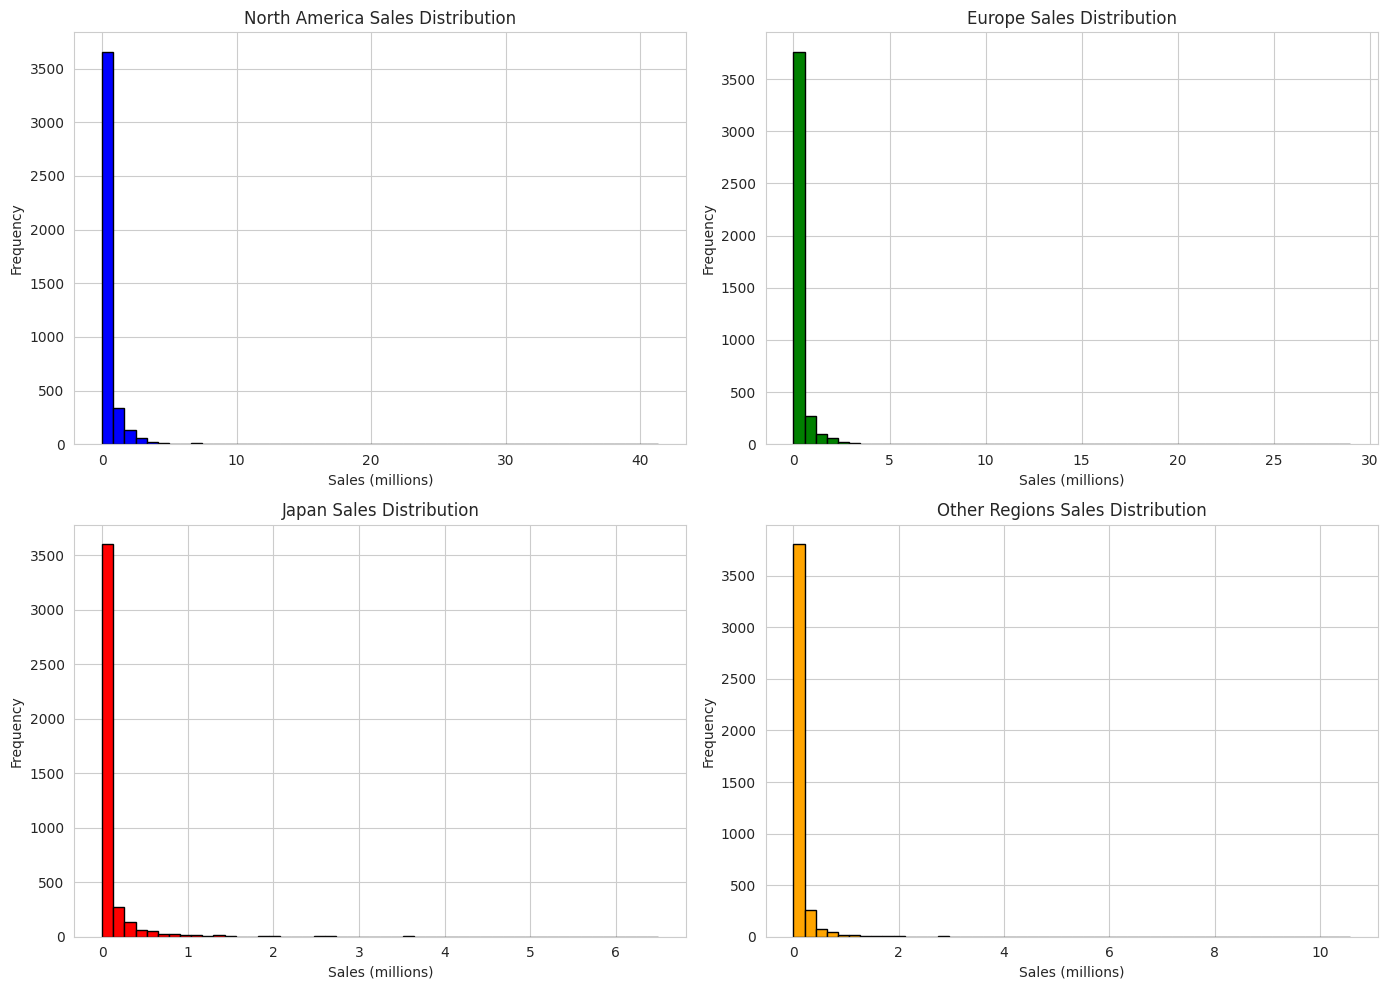

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].hist(df_relevant['NA_Sales'], bins=50, edgecolor='black', color='blue')
axes[0, 0].set_title('North America Sales Distribution')
axes[0, 0].set_xlabel('Sales (millions)')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(df_relevant['EU_Sales'], bins=50, edgecolor='black', color='green')
axes[0, 1].set_title('Europe Sales Distribution')
axes[0, 1].set_xlabel('Sales (millions)')
axes[0, 1].set_ylabel('Frequency')

axes[1, 0].hist(df_relevant['JP_Sales'], bins=50, edgecolor='black', color='red')
axes[1, 0].set_title('Japan Sales Distribution')
axes[1, 0].set_xlabel('Sales (millions)')
axes[1, 0].set_ylabel('Frequency')

axes[1, 1].hist(df_relevant['Other_Sales'], bins=50, edgecolor='black', color='orange')
axes[1, 1].set_title('Other Regions Sales Distribution')
axes[1, 1].set_xlabel('Sales (millions)')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

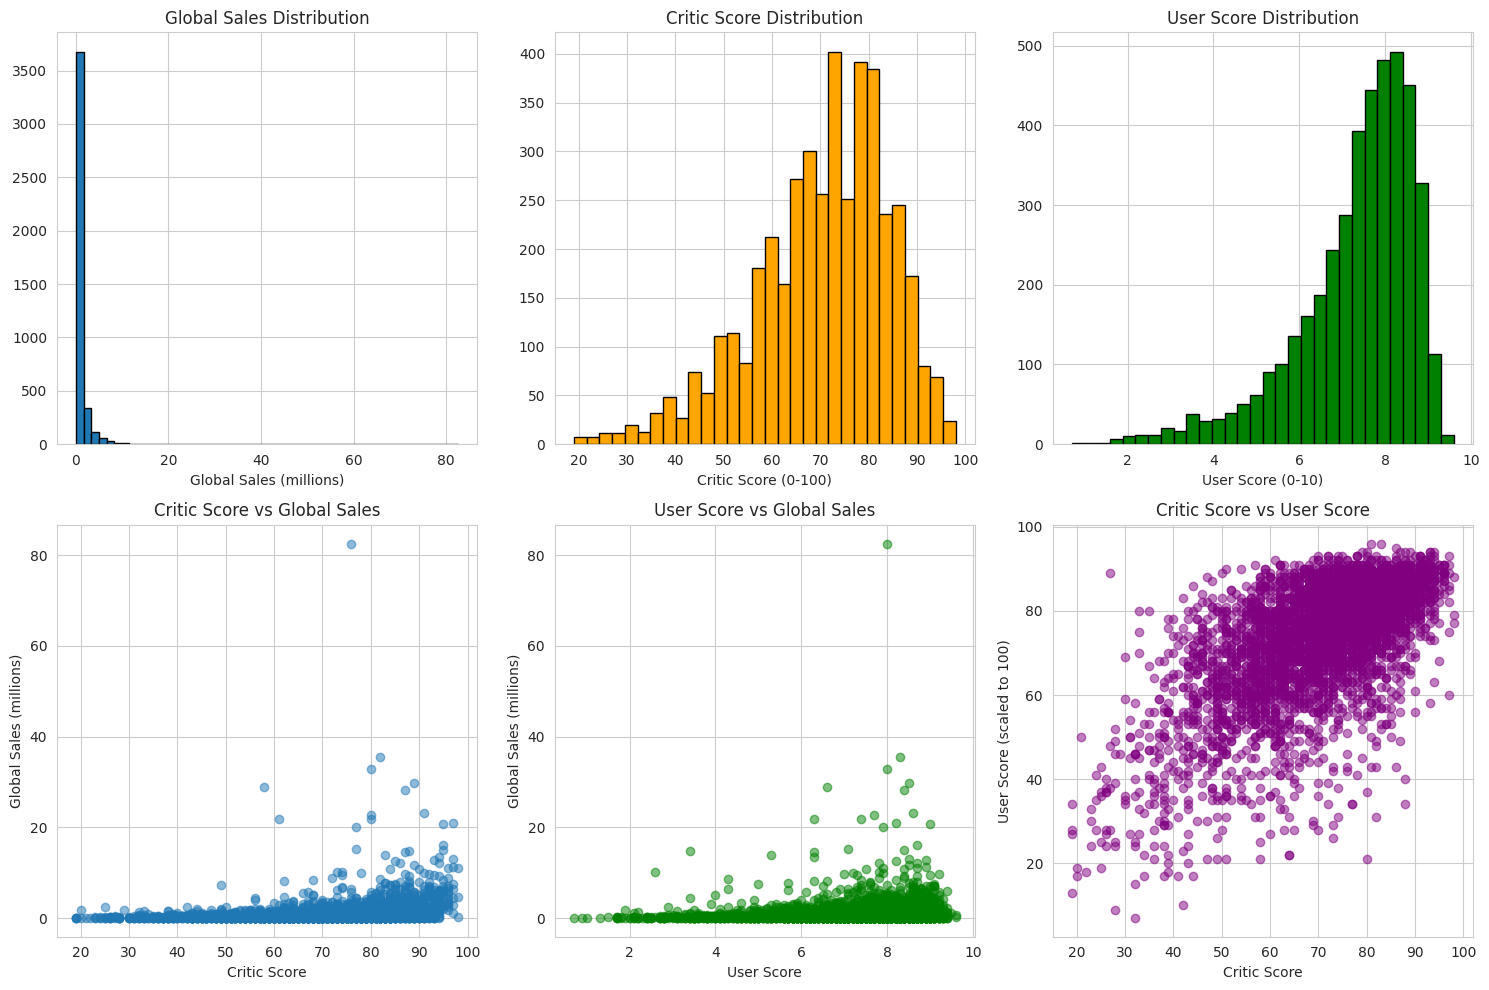

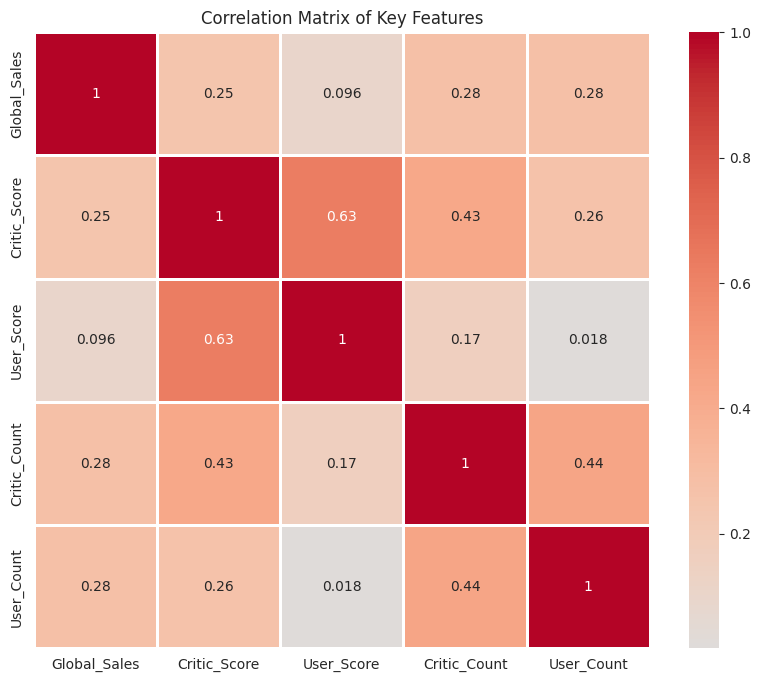

In [28]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# to understand data before clustering
axes[0, 0].hist(df_relevant['Global_Sales'], bins=50, edgecolor='black')
axes[0, 0].set_title('Global Sales Distribution')
axes[0, 0].set_xlabel('Global Sales (millions)')

axes[0, 1].hist(df_relevant['Critic_Score'], bins=30, edgecolor='black', color='orange')
axes[0, 1].set_title('Critic Score Distribution')
axes[0, 1].set_xlabel('Critic Score (0-100)')

axes[0, 2].hist(df_relevant['User_Score'], bins=30, edgecolor='black', color='green')
axes[0, 2].set_title('User Score Distribution')
axes[0, 2].set_xlabel('User Score (0-10)')

axes[1, 0].scatter(df_relevant['Critic_Score'], df_relevant['Global_Sales'], alpha=0.5)
axes[1, 0].set_title('Critic Score vs Global Sales')
axes[1, 0].set_xlabel('Critic Score')
axes[1, 0].set_ylabel('Global Sales (millions)')

axes[1, 1].scatter(df_relevant['User_Score'], df_relevant['Global_Sales'], alpha=0.5, color='green')
axes[1, 1].set_title('User Score vs Global Sales')
axes[1, 1].set_xlabel('User Score')
axes[1, 1].set_ylabel('Global Sales (millions)')

axes[1, 2].scatter(df_relevant['Critic_Score'], df_relevant['User_Score']*10, alpha=0.5, color='purple')
axes[1, 2].set_title('Critic Score vs User Score')
axes[1, 2].set_xlabel('Critic Score')
axes[1, 2].set_ylabel('User Score (scaled to 100)')

plt.tight_layout()
plt.show()


# tinitignan ung correlation between sa variables, answers stuff like "commercial success ~= high critic scores"
correlation_matrix = df_relevant[['Global_Sales', 'Critic_Score', 'User_Score', 'Critic_Count', 'User_Count']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True, linewidths=1)
plt.title('Correlation Matrix of Key Features')
plt.show()

# df_relevant['Critic_User_Diff'] = df_relevant['Critic_Score'] - (df_relevant['User_Score'] * 10)
# print("\nCritic-User Score Difference Statistics:")
# print(df_relevant['Critic_User_Diff'].describe())

# plt.figure(figsize=(10, 6))
# plt.hist(df_relevant['Critic_User_Diff'], bins=50, edgecolor='black', color='coral')
# plt.title('Critic-User Score Difference Distribution')
# plt.xlabel('Critic Score - User Score (both scaled to 100)')
# plt.ylabel('Frequency')
# plt.axvline(x=0, color='red', linestyle='--', label='Perfect Agreement')
# plt.legend()
# plt.show()

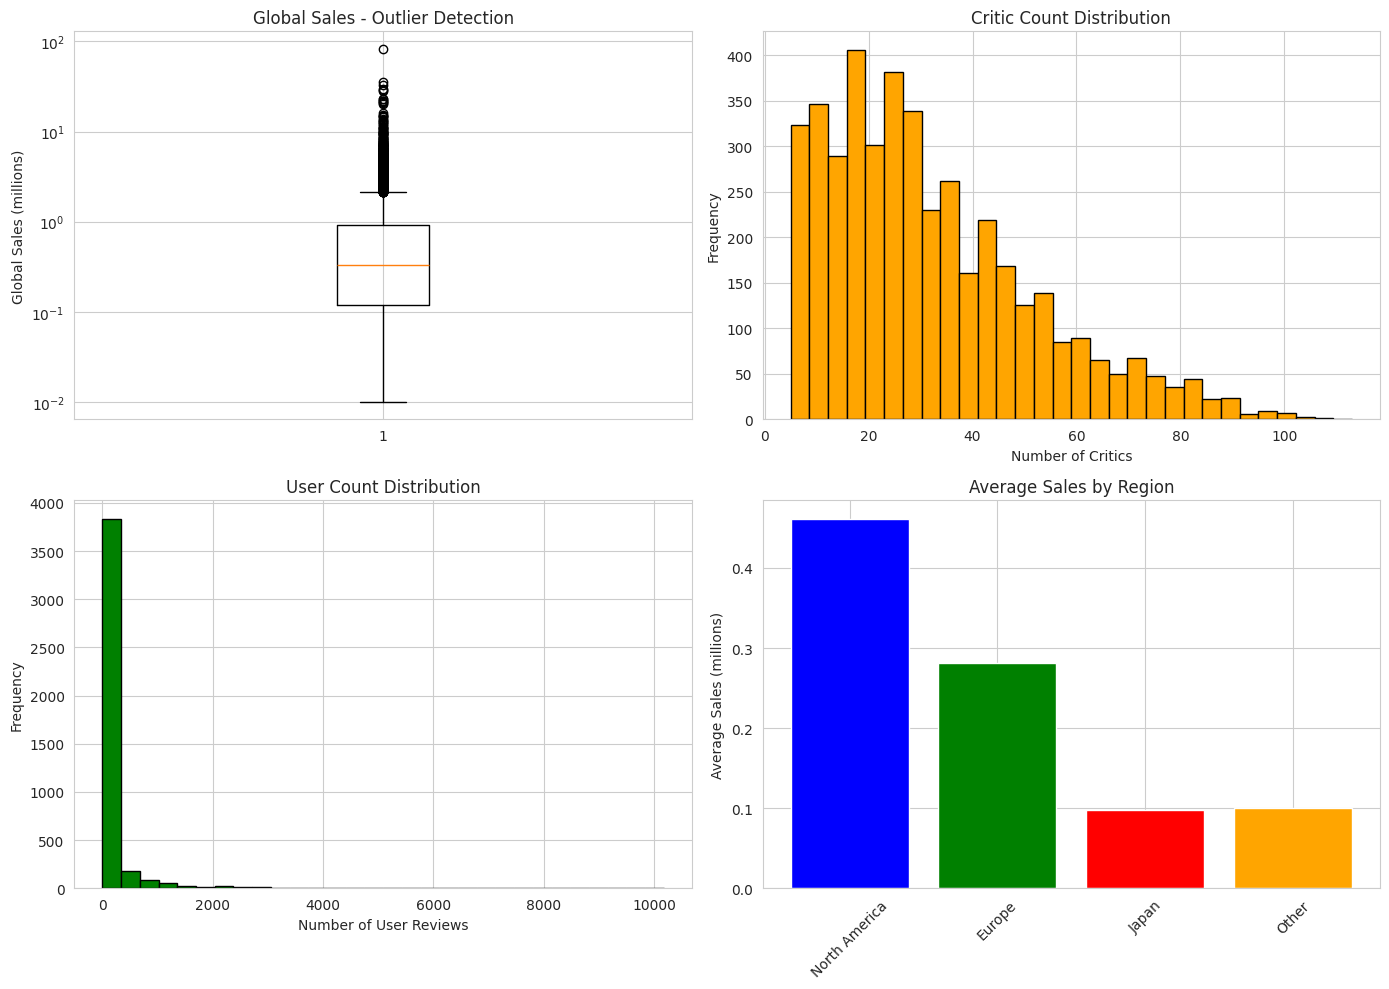


Sales Statistics:
Max Global Sales: 82.53 million
75th percentile: 0.92 million
Median: 0.33 million


In [29]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Boxplot to identify sales outliers
axes[0, 0].boxplot(df_relevant['Global_Sales'])
axes[0, 0].set_title('Global Sales - Outlier Detection')
axes[0, 0].set_ylabel('Global Sales (millions)')
axes[0, 0].set_yscale('log') # gumamit po ako ng log scale kase sobrang napipi ung box dahil sa outlier hahahahahaha

# Review count distributions
axes[0, 1].hist(df_relevant['Critic_Count'], bins=30, edgecolor='black', color='orange')
axes[0, 1].set_title('Critic Count Distribution')
axes[0, 1].set_xlabel('Number of Critics')
axes[0, 1].set_ylabel('Frequency')

axes[1, 0].hist(df_relevant['User_Count'], bins=30, edgecolor='black', color='green')
axes[1, 0].set_title('User Count Distribution')
axes[1, 0].set_xlabel('Number of User Reviews')
axes[1, 0].set_ylabel('Frequency')

# Regional sales comparison
regional_means = [
    df_relevant['NA_Sales'].mean(),
    df_relevant['EU_Sales'].mean(),
    df_relevant['JP_Sales'].mean(),
    df_relevant['Other_Sales'].mean()
]
regions = ['North America', 'Europe', 'Japan', 'Other']

axes[1, 1].bar(regions, regional_means, color=['blue', 'green', 'red', 'orange'])
axes[1, 1].set_title('Average Sales by Region')
axes[1, 1].set_ylabel('Average Sales (millions)')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"\nSales Statistics:")
print(f"Max Global Sales: {df_relevant['Global_Sales'].max():.2f} million")
print(f"75th percentile: {df_relevant['Global_Sales'].quantile(0.75):.2f} million")
print(f"Median: {df_relevant['Global_Sales'].median():.2f} million")

## data preprocessing
done, idocument nalang na mababa ung variance kapag ininclude ung regional sales metric

In [30]:
# Convert to array
df_X = df_relevant[['Global_Sales', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count']].astype(float).to_numpy()

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_X)

X_scaled.shape




(4253, 5)

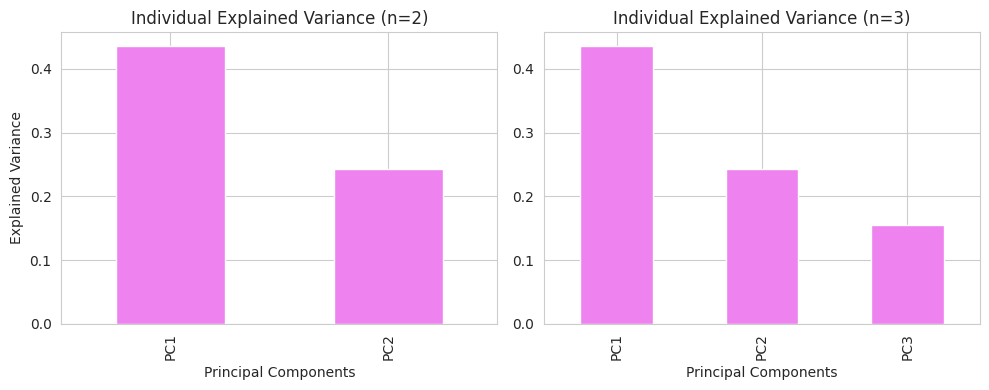

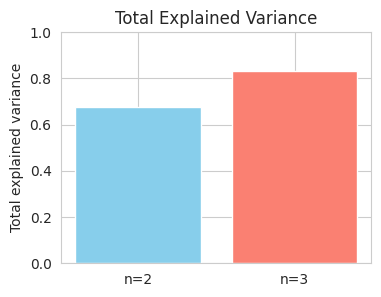

In [ ]:
# Apply PCA with n=2 and n=3
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X_scaled) # n_components=3 provided better results so eto gagamitin natin.
explained_variance = pca.explained_variance_ratio_

pca2 = PCA(n_components=2)
pca2.fit(X_scaled)
explained_variance_2 = pca2.explained_variance_ratio_

# Individual explained variance side-by-side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

pd.DataFrame(explained_variance_2).plot.bar(color='violet', legend=False, ax=axes[0])
axes[0].set_xlabel('Principal Components')
axes[0].set_ylabel('Explained Variance')
axes[0].set_title('Individual Explained Variance (n=2)')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['PC1', 'PC2'])

pd.DataFrame(explained_variance).plot.bar(color='violet', legend=False, ax=axes[1])
axes[1].set_xlabel('Principal Components')
axes[1].set_title('Individual Explained Variance (n=3)')
axes[1].set_xticks([0, 1, 2])
axes[1].set_xticklabels(['PC1', 'PC2', 'PC3'])

plt.tight_layout()
plt.show()

# Total explained variance comparison
total_variance_2 = explained_variance_2.sum()
total_variance_3 = explained_variance.sum()

plt.figure(figsize=(4, 3))
plt.bar(['n=2', 'n=3'], [total_variance_2, total_variance_3], color=['skyblue', 'salmon'])
plt.ylim(0, 1)
plt.ylabel('Total explained variance')
plt.title('Total Explained Variance')
plt.show()

## Plotting the data

In [41]:
import plotly.express as px
import plotly.io as pio

# Set the default renderer to 'vscode'
pio.renderers.default = "vscode"

# Now create and show the figure (use 3-component PCA results)
fig = px.scatter_3d(x=X_reduced[:, 0], y=X_reduced[:, 1], z=X_reduced[:, 2])
fig.show()

## Determining Optimal K Value

### WCSS

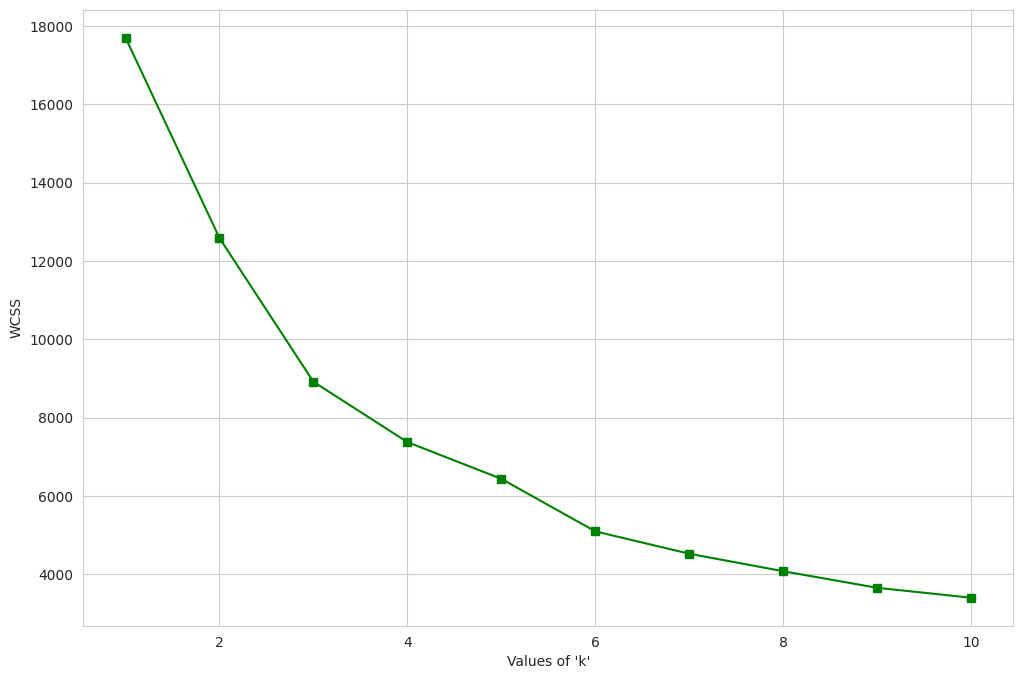

In [33]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 300,
                  n_init = 10, random_state = 0)
kmeans.fit(X_reduced)

labels = kmeans.labels_  # Cluster labels for each point
centroids = kmeans.cluster_centers_  # Cluster centroids

wcss = {}
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X_reduced)
    wcss[i] = kmeans.inertia_

plt.plot(wcss.keys(), wcss.values(), 'gs-')
plt.xlabel("Values of 'k'")
plt.ylabel('WCSS')
plt.show()

## Silhouette Score Analysis

In [ ]:
silhouette_scores = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    labels = kmeans.fit_predict(X_reduced)
    silhouette_scores[k] = silhouette_score(X_reduced, labels)

plt.plot(silhouette_scores.keys(), silhouette_scores.values(), 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.grid(True)
plt.show()

print("Silhouette scores:")
print(silhouette_scores)

## Combined Comparison (WCSS vs Silhouette)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(wcss.keys(), wcss.values(), 'gs-')
axes[0].set_xlabel("Number of clusters (k)")
axes[0].set_ylabel('WCSS')
axes[0].set_title('Elbow Method (WCSS)')
axes[0].grid(True)

axes[1].plot(silhouette_scores.keys(), silhouette_scores.values(), 'bo-')
axes[1].set_xlabel('Number of clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score')
axes[1].grid(True)

plt.tight_layout()
plt.show()

## model training

In [34]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_reduced)
y_kmeans = kmeans.predict(X_reduced)

fig = px.scatter_3d(x=X_reduced[:, 0], y=X_reduced[:, 1], z=X_reduced[:, 2], color=y_kmeans)
fig.show()

## cLuster interpretation and archetype naming

In [35]:
df_relevant['Cluster'] = y_kmeans

print("=== Cluster 0 ===")
display(df_relevant[df_relevant['Cluster'] == 0].head(5))

print("\n=== Cluster 1 ===")
display(df_relevant[df_relevant['Cluster'] == 1].head(5))

print("\n=== Cluster 2 ===")
display(df_relevant[df_relevant['Cluster'] == 2].head(5))

# print("\n=== Cluster 3 ===")
# display(df_relevant[df_relevant['Cluster'] == 3].head(5))

# print("\n=== Cluster 4 ===")
# display(df_relevant[df_relevant['Cluster'] == 4].head(5))


=== Cluster 0 ===


,Name,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Cluster
0,Wii Sports,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,0
2,Mario Kart Wii,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,0
3,Wii Sports Resort,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,0
6,New Super Mario Bros.,11.28,9.14,6.50,2.88,29.80,89.0,65.0,8.5,431.0,0
7,Wii Play,13.96,9.18,2.93,2.84,28.92,58.0,41.0,6.6,129.0,0



=== Cluster 1 ===


,Name,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Cluster
52,Gran Turismo,4.02,3.87,2.54,0.52,10.95,96.0,16.0,8.7,138.0,1
61,Just Dance 3,5.95,3.11,0.00,1.06,10.12,74.0,15.0,7.8,16.0,1
67,Gran Turismo 2,3.88,3.42,1.69,0.50,9.49,93.0,23.0,9.0,135.0,1
68,Just Dance 2,5.80,2.85,0.01,0.78,9.44,74.0,24.0,7.3,24.0,1
74,Mario Party DS,4.40,1.85,1.98,0.68,8.91,72.0,27.0,7.8,85.0,1



=== Cluster 2 ===


,Name,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Cluster
103,Just Dance,3.48,2.99,0.00,0.73,7.20,49.0,21.0,8.0,110.0,2
294,Carnival Games,2.12,1.47,0.05,0.42,4.05,56.0,27.0,6.0,44.0,2
418,Wii Music,1.35,1.11,0.46,0.32,3.25,63.0,43.0,4.6,116.0,2
501,Cooking Mama: Cook Off,1.41,1.12,0.05,0.30,2.89,61.0,37.0,5.3,23.0,2
537,Skylanders: Spyro's Adventure,1.35,1.13,0.00,0.30,2.78,81.0,11.0,5.6,31.0,2


## Final Analysis & Conclusion

put stuff here